# Hign Perfomance Computing. Домашнее задание 6

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving pic.jpg to pic.jpg
User uploaded file "pic.jpg" with length 249081 bytes


In [ ]:
!ls -la

total 260
drwxr-xr-x 1 root root   4096 Dec 11 19:30 .
drwxr-xr-x 1 root root   4096 Dec 11 19:19 ..
drwxr-xr-x 1 root root   4096 Dec 10 17:17 .config
-rw-r--r-- 1 root root 249081 Dec 11 19:30 pic.jpg
drwxr-xr-x 1 root root   4096 Dec  2 22:04 sample_data


In [ ]:
!pip install pycuda

     |████████████████████████████████| 1.6MB 13.6MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620933 sha256=e89df869e8533e7e6c88b6b173ae422b3e55997ac2f020eed48ff80b881d1992
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=1c08eb7bf18b96ead196687968767b52306c90f7add3e25a1a1231a9ac84269d
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


In [ ]:
!nvidia-smi

Fri Dec 11 19:31:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Картинка

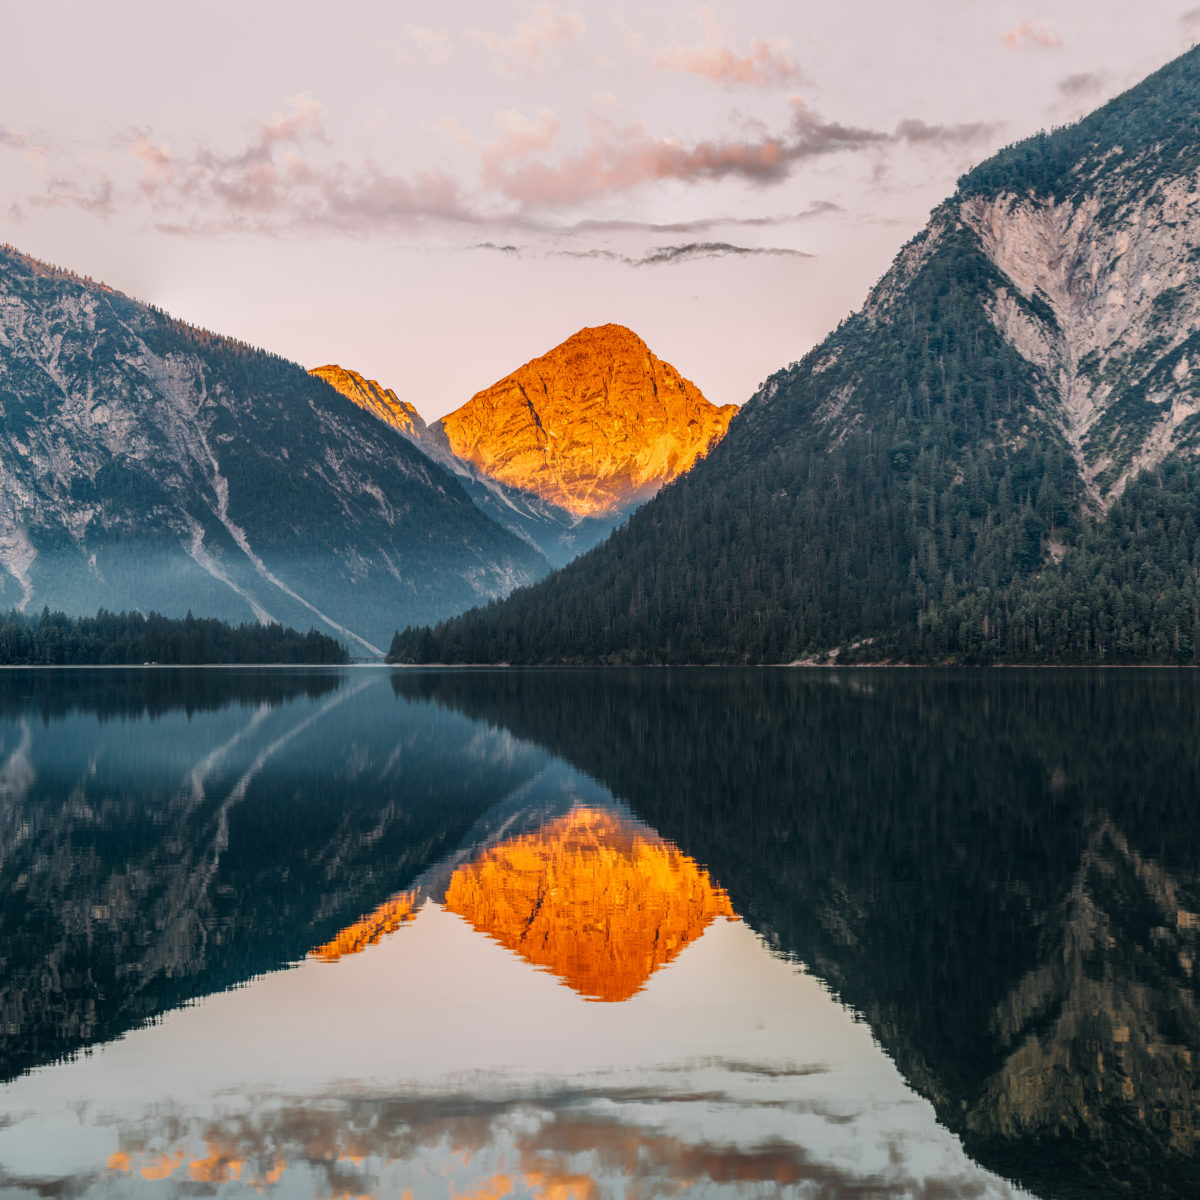

In [ ]:
import PIL.Image as img


image = img.open("pic.jpg")
display(image)

## Размытие по шаблону

In [ ]:
TEMPLATE_FILTER = '''
__global__ void applyTemplateFilter(const unsigned char *inputChannel, unsigned char *outputChannel,
                             const unsigned int height, const unsigned int width,
                             const float *filter, const unsigned int filterSize, const float filterSum) {
    const unsigned int row = threadIdx.x + blockIdx.x * blockDim.x;
    const unsigned int col = threadIdx.y + blockIdx.y * blockDim.y;
    if (row < height && col < width) {
        const int filterHalf = filterSize / 2;
        float blur = 0.0;
        for (int i = -filterHalf; i <= filterHalf; i++) {
            for (int j = -filterHalf; j <= filterHalf; j++) {
                const unsigned int x = max(0, min(height - 1, row + i));
                const unsigned int y = max(0, min(width - 1, col + j));

                const float w = filter[(i + filterHalf) * filterSize + (j + filterHalf)];
                blur += w * inputChannel[x * width + y];
            }
        }
        outputChannel[row * width + col] = static_cast<unsigned char>(blur / filterSum);
    }
}

'''

In [ ]:
import math as mt

import numpy as np
import pycuda.autoinit
from pycuda import driver
from pycuda import compiler


BLOCK_SIZE = 16


def template_filter_cuda(src, filter):
    assert filter.shape[0] == filter.shape[1] and filter.shape[0] % 2
    filter_size = filter.shape[0]
    filter_sum = filter.sum()
    height, width = src.shape[:2]

    dim_grid_x = mt.ceil(height / BLOCK_SIZE)
    dim_grid_y = mt.ceil(width / BLOCK_SIZE)

    mod = compiler.SourceModule(TEMPLATE_FILTER)
    apply_template_filter = mod.get_function('applyTemplateFilter')

    res = np.empty_like(src)
    for color in range(src.shape[2]):
        channel = src[:, :, color].copy()
        apply_template_filter(
            driver.In(channel),
            driver.Out(channel),
            np.uint32(height),
            np.uint32(width),
            driver.In(filter),
            np.uint32(filter_size),
            np.float32(filter_sum),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(dim_grid_x, dim_grid_y)
        )
        res[:, :, color] = channel

    return res

In [ ]:
def template_filter_cpu(src, filter):
    assert filter.shape[0] == filter.shape[1] and filter.shape[0] % 2
    filter_size = filter.shape[0]
    filter_sum = filter.sum()
    height, width = src.shape[:2]

    res = np.empty_like(src)

    filter_half = filter_size // 2
    for color in range(src.shape[2]):
      for row in range(height):
          for col in range(width):
                blur = 0.0
                for i in range(-filter_half, filter_half + 1):
                    for j in range(-filter_half, filter_half + 1):
                        x = max(0, min(height - 1, row + i))
                        y = max(0, min(width - 1, col + j))

                        w = filter[i + filter_half, j + filter_half]
                        blur += w * src[x, y, color];
                res[row, col, color] = int(blur / filter_sum)
    return res

In [ ]:
def perform_filter(image, cpu_filter_func, cuda_filter_func):
    src = np.array(image)

    def process_filter(src, filter_func):
        res = filter_func(src)
        res_image = img.fromarray(res)
        display(res_image)
        return res, res_image

    res_cpu, _ = process_filter(src, cpu_filter_func)
    res_cuda, _ = process_filter(src, cuda_filter_func)

    return res_cpu, res_cuda

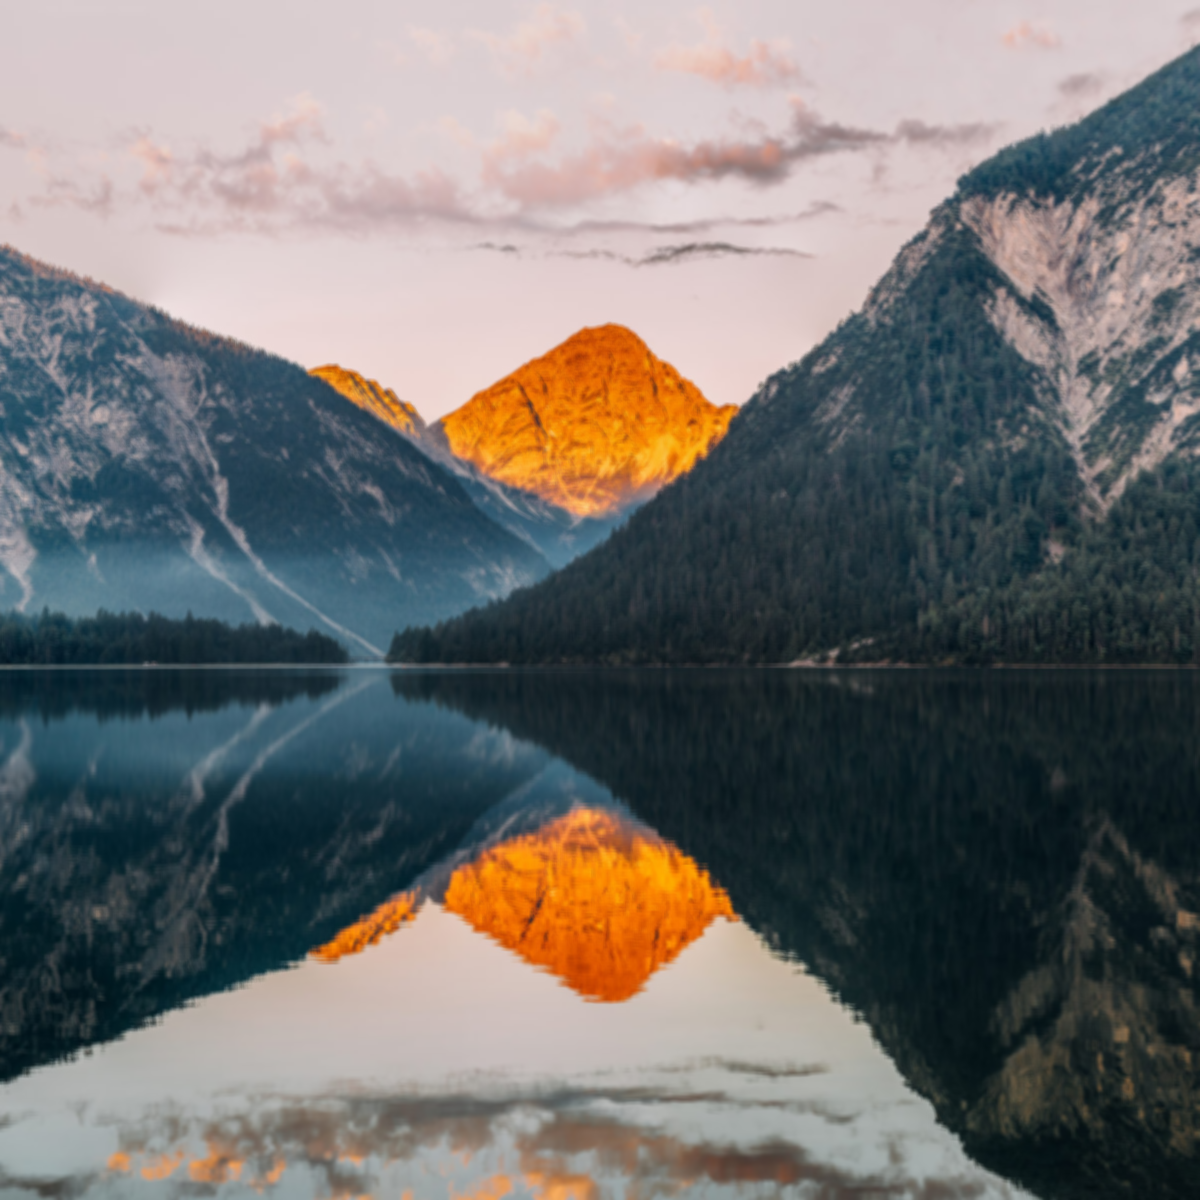

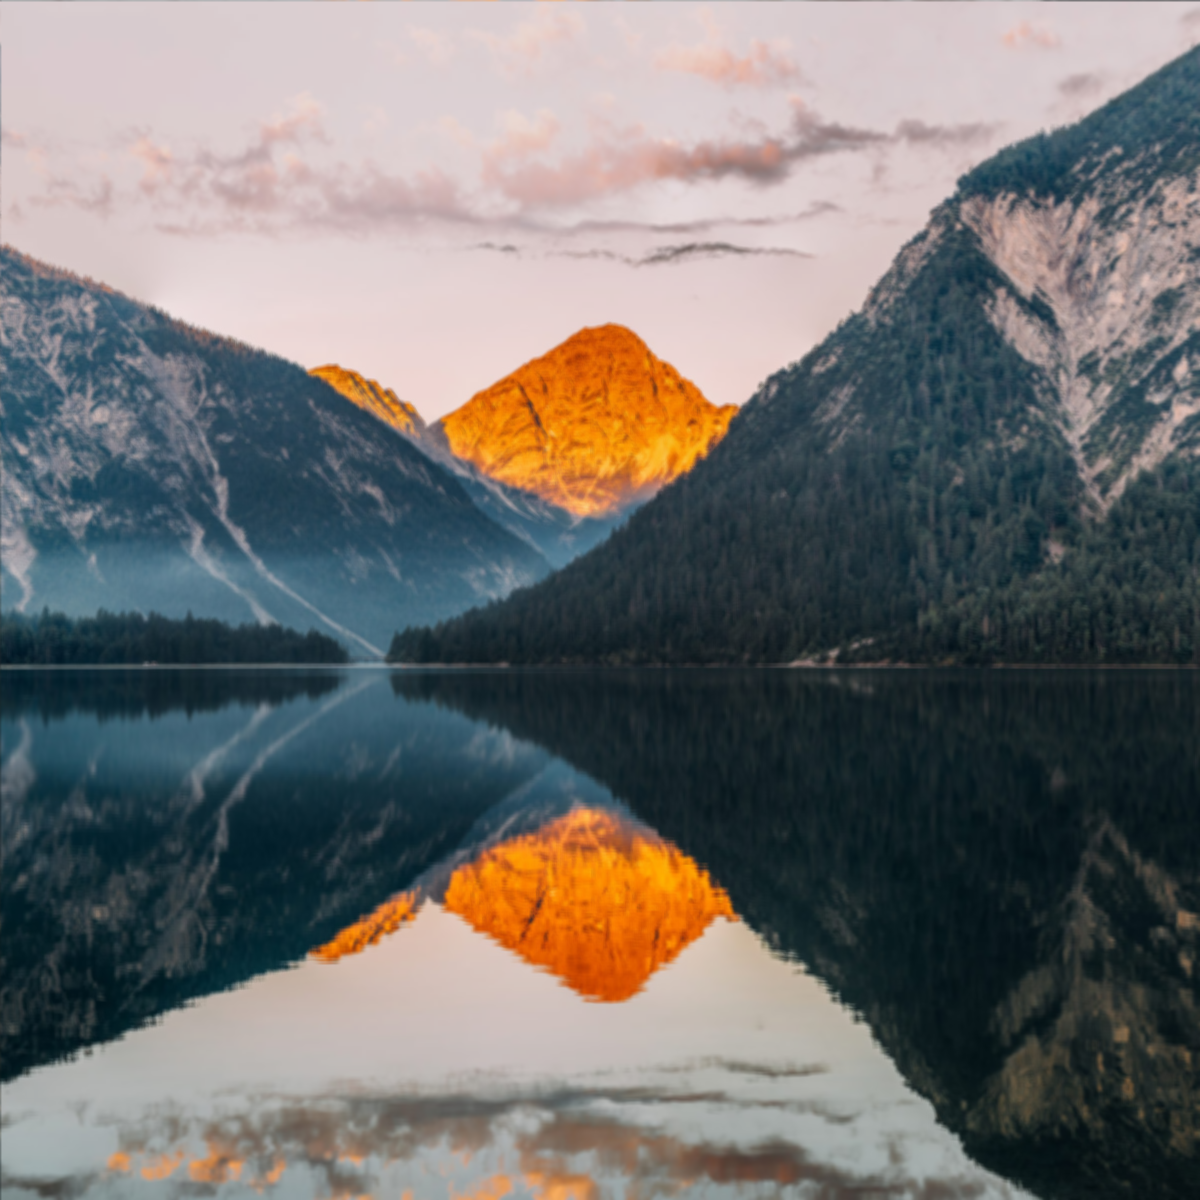

In [ ]:
from functools import partial


filter = np.random.random((5, 5)).astype(np.float32)
image = img.open("pic.jpg")

res_cpu, res_cuda = perform_filter(
    image,
    partial(template_filter_cpu, filter=filter),
    partial(template_filter_cuda, filter=filter),
)

## Медианный фильтр

In [ ]:
MEDIAN_FILTER = '''
__global__ void applyMedianFilter(const unsigned char *inputChannel, unsigned char *outputChannel,
                             const unsigned int height, const unsigned int width,
                             const unsigned int filterSize) {
    const unsigned int row = threadIdx.x + blockIdx.x * blockDim.x;
    const unsigned int col = threadIdx.y + blockIdx.y * blockDim.y;
    if (row < height && col < width) {
        const int filterHalf = filterSize / 2;
        unsigned char* values = new unsigned char[filterSize * filterSize];
        for (int i = -filterHalf; i <= filterHalf; i++) {
            for (int j = -filterHalf; j <= filterHalf; j++) {
                const unsigned int x = max(0, min(height - 1, row + i));
                const unsigned int y = max(0, min(width - 1, col + j));

                values[(i + filterHalf) * filterSize + (j + filterHalf)] = inputChannel[x * width + y];
            }
        }
        for (unsigned int i = 0; i <= filterSize * filterSize / 2; i++) {
            unsigned int pos = i;
            for (unsigned j = i + 1; j < filterSize * filterSize; j++) {
                if (values[pos] > values[j]) {
                    pos = j;
                }
            }
            unsigned char tmp = values[pos];
            values[pos] = values[i];
            values[i] = tmp;
        }
        outputChannel[row * width + col] = values[filterSize * filterSize / 2];
        delete[] values;
    }
}

'''

In [ ]:
def median_filter_cuda(src, filter_size):
    assert filter_size % 2
    height, width = src.shape[:2]

    dim_grid_x = mt.ceil(height / BLOCK_SIZE)
    dim_grid_y = mt.ceil(width / BLOCK_SIZE)

    mod = compiler.SourceModule(MEDIAN_FILTER)
    apply_template_filter = mod.get_function('applyMedianFilter')

    res = np.empty_like(src)
    for color in range(src.shape[2]):
        channel = src[:, :, color].copy()
        apply_template_filter(
            driver.In(channel),
            driver.Out(channel),
            np.uint32(height),
            np.uint32(width),
            np.uint32(filter_size),
            block=(BLOCK_SIZE, BLOCK_SIZE, 1),
            grid=(dim_grid_x, dim_grid_y)
        )
        res[:, :, color] = channel

    return res

In [ ]:
def median_filter_cpu(src, filter_size):
    assert filter_size % 2
    height, width = src.shape[:2]

    res = np.empty_like(src)

    filter_half = filter_size // 2
    for color in range(src.shape[2]):
      for row in range(height):
          for col in range(width):
                lst = []
                for i in range(-filter_half, filter_half + 1):
                    for j in range(-filter_half, filter_half + 1):
                        x = max(0, min(height - 1, row + i))
                        y = max(0, min(width - 1, col + j))

                        lst.append(src[x, y, color])
                res[row, col, color] = sorted(lst)[filter_size ** 2 // 2 + 1]
    return res

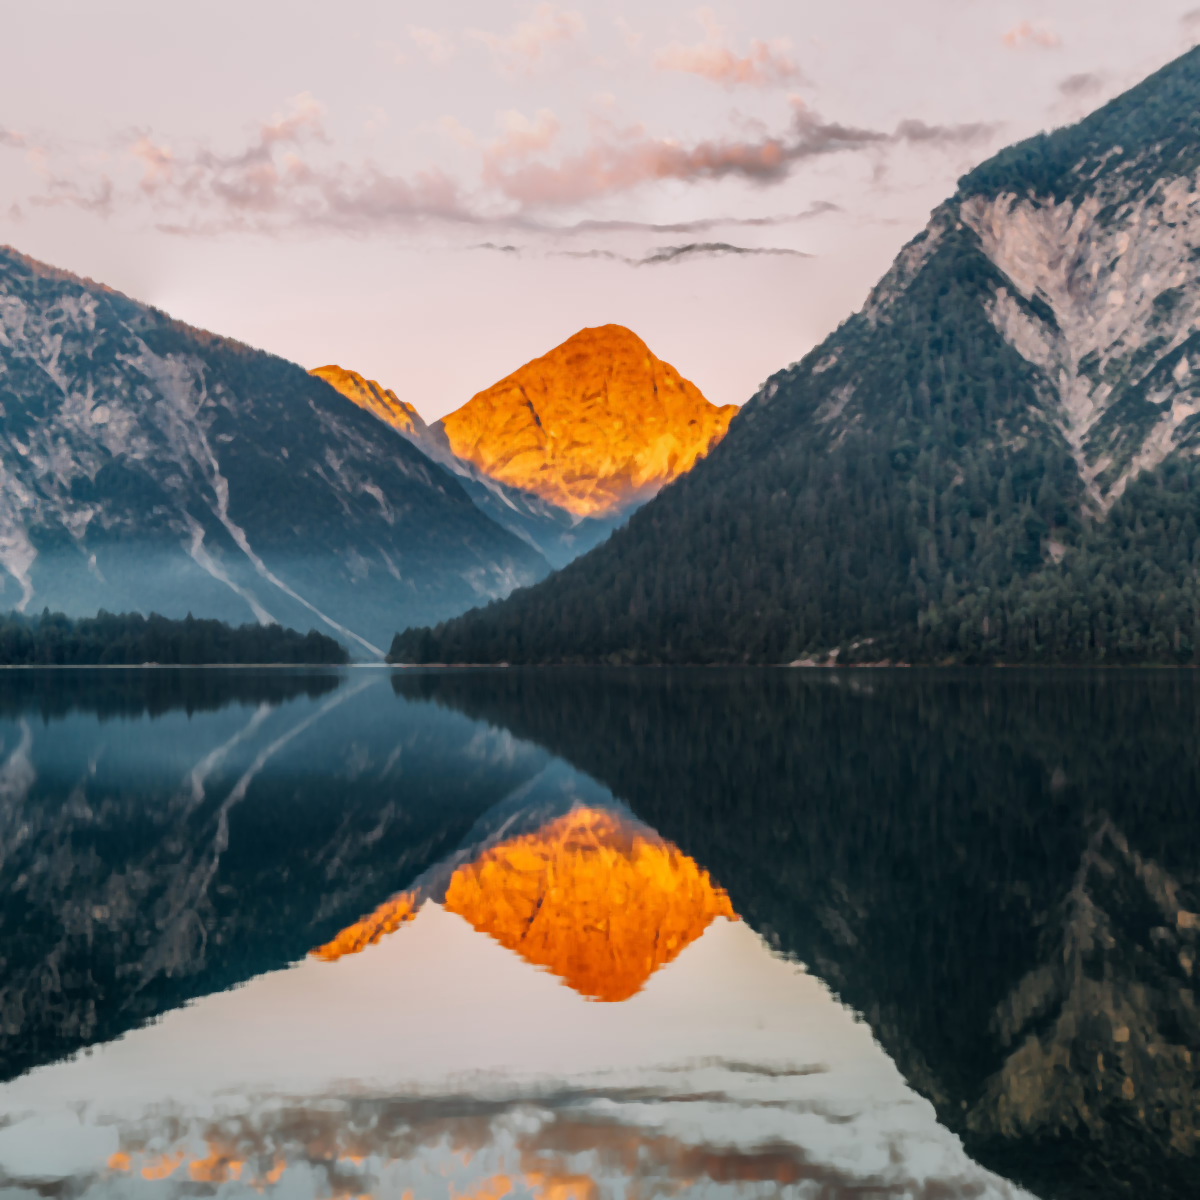

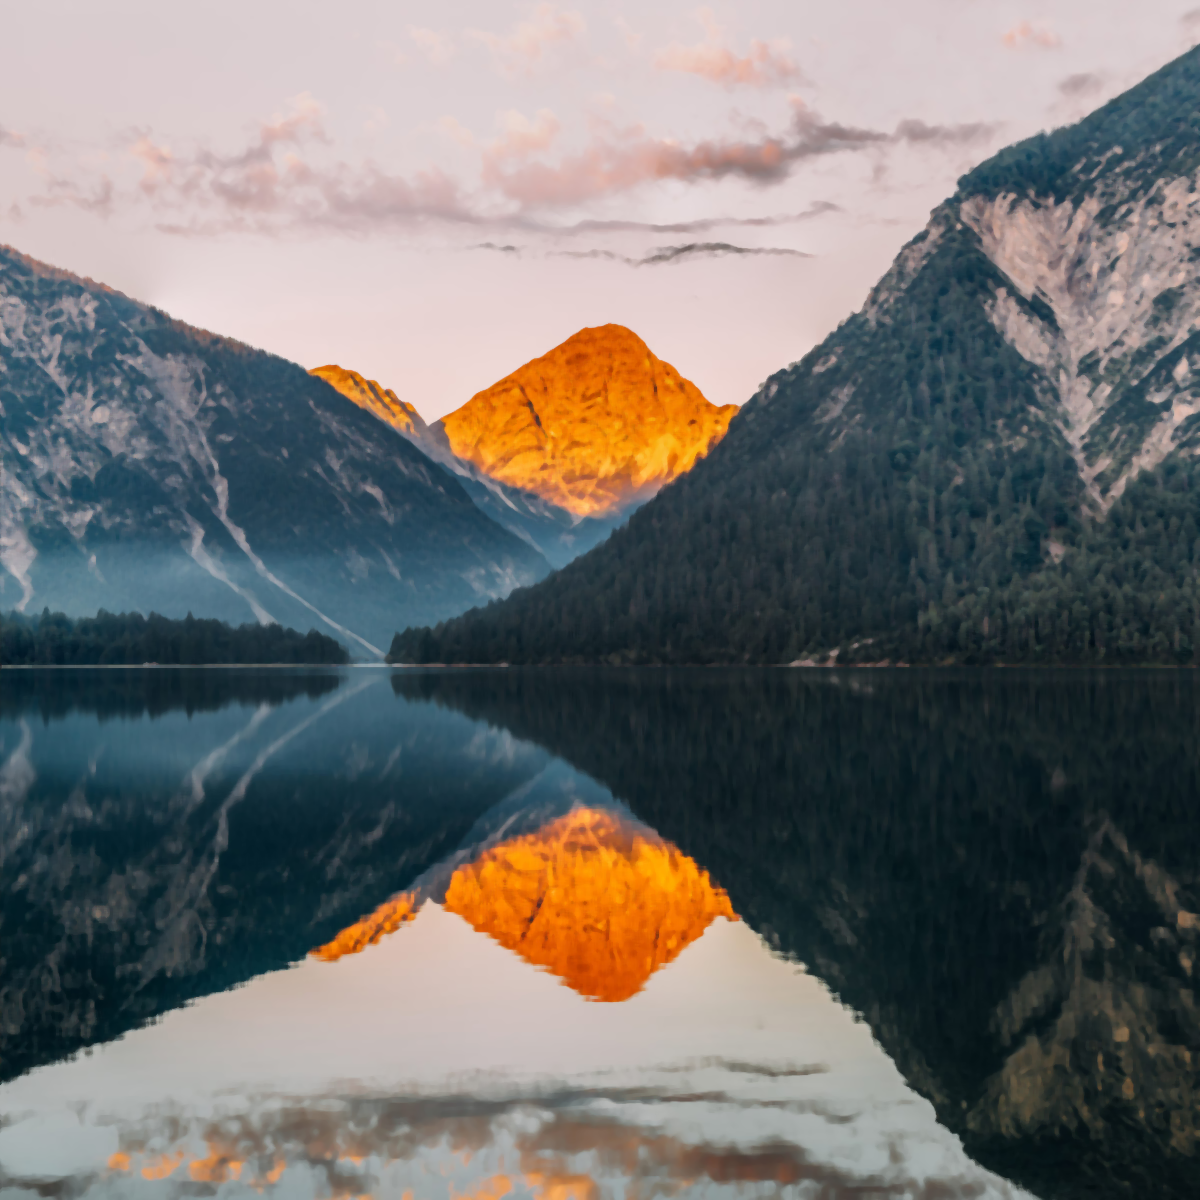

In [ ]:
image = img.open("pic.jpg")

res_cpu, res_cuda = perform_filter(
    image,
    partial(median_filter_cpu, filter_size=5),
    partial(median_filter_cuda, filter_size=5),
)